## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [3]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [4]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the additive inflation for the dynamical and observation models

Define the time span of interest

In [5]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, tf/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [6]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [7]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

In [8]:
σx = 1e-2
σy = 1.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
)

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\boldsymbol{x}^i$ o generate i.i.d. samples from the system’s invariant (long-time) distribution, we sampleninitialconditions from a multivariate standard Gaussian distribution.  For each sample, we run the ODEin equation(SM.25)forT=  40,000steps using the Runge-Kutta method with a time-step of∆t= 0.01. The samples of the state at the final time are then i.i.d. samples from the push-forwarddistribution of the standard Gaussian through the nonlinear forward dynamics forTsteps

In [9]:
# Number of runs
Ne = 500
# Zero vector of the size of the state
x0 = rand(π0)

# Time stepp
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, x0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [-0.8103785455370174, 1.2234854981603123, 0.9946430822593753]

Create cache to store the different final solutions

In [16]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [17]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(π0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    # Store the state
    X[Ny+1:Ny+Nx,i] .= deepcopy(sol.u[1])
end
# Apply the process noise
ϵx(X, Ny+1, Ny+Nx)
# Generate the observations
observe(h, X, tf, Ny, Nx)
# Apply the observation noise
ϵy(X, 1, Ny)

In [18]:
m = 30
S = HermiteMap(m, X; diag = true)

HermiteMap(30, 6, LinearTransform(6, [0.42668765187938656, 0.3760455880867174, 23.542264263817444, 0.37492252277894955, 0.3907237521462497, 23.54131224387214], [8.299025339052431 0.0 … 0.0 0.0; 0.0 9.560850443781833 … 0.0 0.0; … ; 0.0 0.0 … 9.539400739165213 0.0; 0.0 0.0 … 0.0 8.857661111585214], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [19]:
@time optimize(S, X, "kfolds"; withqr = true, verbose = false, hessprecond = false)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.245660 seconds (33.15 M allocations: 106.665 GiB, 5.12% gc time)


HermiteMap(30, 6, LinearTransform(6, [0.42668765187938656, 0.3760455880867174, 23.542264263817444, 0.37492252277894955, 0.3907237521462497, 23.54131224387214], [8.299025339052431 0.0 … 0.0 0.0; 0.0 9.560850443781833 … 0.0 0.0; … ; 0.0 0.0 … 9.539400739165213 0.0; 0.0 0.0 … 0.0 8.857661111585214], true), MapComponent[Map component of dimension 1 with Nψ 7 active features
, Map component of dimension 2 with Nψ 19 active features
, Map component of dimension 3 with Nψ 21 active features
, Map component of dimension 4 with Nψ 24 active features
, Map component of dimension 5 with Nψ 22 active features
, Map component of dimension 6 with Nψ 24 active features
])

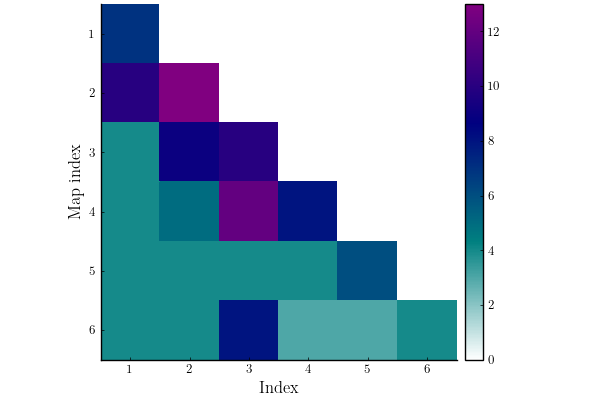

In [20]:
plot(S)

In [21]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
     5.09065e8      1.03132e6      5.58764e5  …  62065.0            1.11385e6
     1.03132e6      9.36699e8      6.00351e5         6.02162e8  11622.8
     5.58764e5      6.00351e5      5.02621e8         2.74983e5      5.41869e8
     5.07128e8      9.86606e7  97350.4               7.03697e7      2.73007e6
 62065.0            6.02162e8      2.74983e5         9.39201e8      1.77635e5
     1.11385e6  11622.8            5.41869e8  …      1.77635e5      9.72216e8

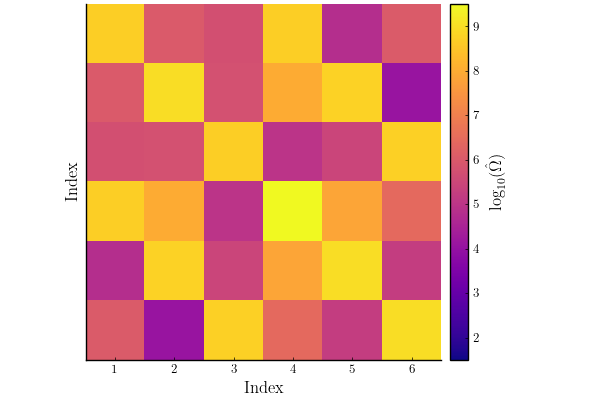

In [22]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

In [23]:
smf = StochMapFilter(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, Inf, false)

Stochastic Map Filter with filtered = false


In [24]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

Set initial condition of the true system

In [34]:
x0 = rand(model.π0);

In [35]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [38]:
Ne = 300 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×300 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
  0.901095  -0.706439   -2.3234    …  -1.19913    0.592851   2.03478
 -0.542905   0.113512   -0.424144      2.40995    0.955889  -0.723862
  1.01365   -0.0242831   1.1972        0.715918  -1.66693   -0.135384

In [39]:
Xsmf = seqassim(F, data, 20, model.ϵx, smf, deepcopy(X), model.Ny, model.Nx, t0);

t = 0.1
getcoeff(M[6]) = [18.613373191435628, 127.14095875751372, 1424.0239547342062, -436.81153065309627, -12.345492933624485, -123.36043793016671, -1858.9947772473097, 570.0401158825844, -251.69034697301686, 110.13081042096019, -21.071877915236087, -85.5701949382917, -41.421409776482236, -40.07263054957377, 83.21987468807853, 0.9730139442021972, -14.19136655493568, 9.26255370308403, -7.973025814648927, 76.75911961688746, 46.94798439997416, -55.543505037236336, -20.662574575393588, 74.6529835294255]


┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/mat/.julia/packages/LineSearches/Ki4c5/src/hagerzhang.jl:148
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

t = 0.2
getcoeff(M[6]) = [18.613373191436537, 127.14095875751411, 1424.023954734206, -436.81153065309604, -12.345492933624385, -123.36043793016667, -1858.9947772473101, 570.0401158825844, -251.69034697301674, 110.13081042096012, -21.071877915236065, -85.57019493829173, -41.42140977648223, -40.07263054957376, 83.21987468807859, 0.9730139442022006, -14.191366554935682, 9.26255370308401, -7.973025814648934, 76.75911961688749, 46.947984399974125, -55.54350503723632, -20.662574575393577, 74.65298352942553]


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

t = 0.30000000000000004
getcoeff(M[6]) = [17.562703432180577, 127.14800757138181, 1511.0177905955934, -510.06192243446276, 6.922368323584266, -183.29587553073173, -1945.4576583831815, 641.4271507396948, -269.8101478010518, 169.52947018441196, -19.78569635699711, -85.57019493829172, -41.421409776482264, -40.0726305495738, 83.52020031691598, -1.3393036430028848, -14.191366554935671, 9.262553703084004, -7.973025814648934, 76.75911961688745, 46.947984399974125, -55.54350503723632, -20.662574575393577, 74.65298352942553]


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/mat/.julia/packages/LineSearches/Ki4c5/src/hagerzhang.jl:148
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

t = 0.4
getcoeff(M[6]) = [17.478639136940338, 127.34082384977467, 9.33205502347445e9, 2.31389239093551e8, 2.6287614751954737e9, 1.8850360978660455e8, -9.332200289280502e9, -2.2955598545201164e8, -2.628966132529501e9, -1.8701624026970178e8, -18.93168314953425, -85.5701721149137, -41.42140977648226, -40.07262617022324, 83.56831477015422, -1.787066850465746, -14.19136655493567, 9.262553703083999, -7.973025814648935, 76.75911961689864, 46.947984399958635, -55.543505037237146, -20.662574575393585, 74.65298352942555]


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

t = 0.5
getcoeff(M[6]) = [34.85720730319557, 128.325943041832, -2.063638997847722e14, 2.8655266665705805e13, -4.791211028633255e14, -2.65260493396684e13, -2.4427056183585812e13, -4.429037426648406e13, 1.5492951588688906e14, -1.7148375243472092e13, -14.047884286211856, -85.16617290195376, -41.42140977648231, -39.98380619104505, 83.0489157526792, -4.139615713788073, -14.191366554935664, 9.262553703083999, -7.973025814648936, 76.75911961682753, 46.94798440002644, -55.543505037595516, -20.66257457539359, 74.65298352942555]


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/mat/.julia/packages/LineSearches/Ki4c5/src/hagerzhang.jl:148
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/ma

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

t = 0.6000000000000001
getcoeff(M[6]) = [-2.215910519422333e8, 128.25761647577815, -2.0636156884882975e14, 2.863523285645e13, -4.7911754395477706e14, -2.656618974605519e13, -2.4427397094983125e13, -4.4194344560278e13, 1.5492974194647044e14, -1.7054436193264914e13, -3.5792064383938456e9, 1.5343886941830397e7, -9.203351034299479e8, -1.6945926497922285e9, 3.1959952293574774e8, 2.521927958438259e9, -14.191370102479175, 9.262555712187693, -7.9730280928660875, 76.7067342735948, 1.135111028905628e9, -1.3878946270035206e10, -8.575265152148662e8, 1.0452017263709435e9]


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instabi

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

t = 0.7000000000000001
getcoeff(M[6]) = [-2.15697361125e8, 128.25761692620026, -2.063615735487887e14, 2.8635232450362875e13, -4.791175423363047e14, -2.656618962019867e13, -2.442739710670949e13, -4.4194344493818625e13, 1.549297419513821e14, -1.705443618385659e13, -3.579245612132824e9, 1.5348768411447607e7, -9.203352245155256e8, -1.694587101751149e9, 3.195988322251145e8, 2.5219250143054047e9, -14.191370102682738, 9.262555712227897, -7.97302809301481, 76.70673392443173, 1.1351110289056273e9, -1.387894627003521e10, -8.575265152148662e8, 1.0452017263709435e9]


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instabi

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

t = 0.8
getcoeff(M[6]) = [1.2060350470102006e23, 2.00372452957174e7, -8.705999512687037e23, -1.4713980541464776e28, -1.7144958817999355e27, 6.682277016482003e23, 7.565479832513223e11, 3.81876954696629e17, 7.732105068937216e15, -5.298198641901568e16, -1.9847201070619034e17, -8.629454733574144e15, -9.203352278486862e8, -1.6945870852030487e9, 3.195988304612045e8, 2.521925044692749e9, -14.191370102682715, 9.262555712227691, -7.973028093014824, 76.70673416374487, 1.135111028905627e9, -1.3878946270035206e10, -8.575265152148285e8, 1.0452017263709433e9]


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/yEguR/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBas

LoadError: [91mSingularException(7)[39m

In [29]:
mean_hist(Xsmf)[1,:]

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [30]:
data.xt

3×1000 Array{Float64,2}:
 -0.235157  -0.856829  -2.8585     -8.98857  …   5.36724  11.486   15.8175
 -0.615802  -1.92622   -6.23515   -18.5666       9.68995  18.8969  13.8843
 -0.522801  -0.334933   0.376606    6.58208     11.5129   19.7567  38.8349

In [31]:
plot(data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,:])
plot!(data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")


LoadError: [91mUndefVarError: nb not defined[39m

In [32]:
# Plot the first component of the state over time
nb = 1
ne = 499
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "Stochastic Map Filter")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [33]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.